In [1]:
import torch
import torchvision
import torchvision.transforms as transforms


# 实战：训练图像分类器

我们将上一节的内容投入实战，训练一个图像分类器来对 CIFAR10 数据集中的图像进行分类。


## 1. 加载和标准化 CIFAR-10

CIFAR-10 是一个常用的数据集，包含 10 个类别的 60000 张 32x32 的彩色图像。训练集中每个类别有 5000 张图像，测试集中每个类别有 1000 张图像。

![CIFAR-10 数据集中的图像示例](https://pytorch.org/tutorials/_images/cifar10.png)

我们将使用 torchvision 来加载 CIFAR-10 数据集。

我们还需要对数据进行归一化、标准化。归一化即将数据映射到 $[0,1]$ 区间，标准化即将数据映射到均值为 0，标准差为 1 的分布中（减去均值，再除以标准差）。


In [2]:
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
	[transforms.ToTensor(),
	 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # 归一化

batch_size = 4 # 批处理大小

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform) # 下载训练数据集
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2) # 加载训练数据集

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform) # 下载测试数据集
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2) # 加载测试数据集

classes = (
	"apple",
	"aquarium_fish",
	"baby",
	"bear",
	"beaver",
	"bed",
	"bee",
	"beetle",
	"bicycle",
	"bottle",
	"bowl",
	"boy",
	"bridge",
	"bus",
	"butterfly",
	"camel",
	"can",
	"castle",
	"caterpillar",
	"cattle",
	"chair",
	"chimpanzee",
	"clock",
	"cloud",
	"cockroach",
	"couch",
	"cra",
	"crocodile",
	"cup",
	"dinosaur",
	"dolphin",
	"elephant",
	"flatfish",
	"forest",
	"fox",
	"girl",
	"hamster",
	"house",
	"kangaroo",
	"keyboard",
	"lamp",
	"lawn_mower",
	"leopard",
	"lion",
	"lizard",
	"lobster",
	"man",
	"maple_tree",
	"motorcycle",
	"mountain",
	"mouse",
	"mushroom",
	"oak_tree",
	"orange",
	"orchid",
	"otter",
	"palm_tree",
	"pear",
	"pickup_truck",
	"pine_tree",
	"plain",
	"plate",
	"poppy",
	"porcupine",
	"possum",
	"rabbit",
	"raccoon",
	"ray",
	"road",
	"rocket",
	"rose",
	"sea",
	"seal",
	"shark",
	"shrew",
	"skunk",
	"skyscraper",
	"snail",
	"snake",
	"spider",
	"squirrel",
	"streetcar",
	"sunflower",
	"sweet_pepper",
	"table",
	"tank",
	"telephone",
	"television",
	"tiger",
	"tractor",
	"train",
	"trout",
	"tulip",
	"turtle",
	"wardrobe",
	"whale",
	"willow_tree",
	"wolf",
	"woman",
	"worm",
) # 类别


Files already downloaded and verified
Files already downloaded and verified


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 2. 定义卷积神经网络

这一次，我们需要将上一节的神经网络改为接受 RGB 三个通道的图像，而不是单通道的图像。


In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(12, 32, 5)
        self.fc1 = nn.Linear(32 * 5 * 5, 720)
        self.fc2 = nn.Linear(720, 420)
        self.fc3 = nn.Linear(420, 100)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()


## 3. 定义损失函数和优化器


In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

net.to(device)

Net(
  (conv1): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=720, bias=True)
  (fc2): Linear(in_features=720, out_features=420, bias=True)
  (fc3): Linear(in_features=420, out_features=100, bias=True)
)

## 4. 训练网络


In [6]:
for epoch in range(16):  # 循环遍历数据集多次

	running_loss = 0.0
	for i, data in enumerate(trainloader, 0):
		# enumerate() 函数用于将一个可遍历的数据对象 (如列表、元组或字符串) 组合为一个索引序列，
		# 同时列出数据和数据下标，一般用在 for 循环当中。
		inputs, labels = data # 获取输入，形式为 [inputs, labels]
		inputs, labels = inputs.to(device), labels.to(device)

		optimizer.zero_grad()

		outputs = net(inputs)
		loss = criterion(outputs, labels)
		loss.backward()
		optimizer.step()

		# 打印状态信息
		running_loss += loss.item()
		if i % 2000 == 1999: # 每 2000 个 mini-batches 打印一次训练状态
			print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
			running_loss = 0.0

	correct = 0
	total = 0
	# 因为我们不需要进行梯度计算，所以我们使用 torch.no_grad() 来减少内存开销
	with torch.no_grad():
		for data in testloader:
			images, labels = data
			inputs, labels = inputs.to(device), labels.to(device)
			outputs = net(images)
			_, predicted = torch.max(outputs.data, 1) # 取得分最高的那个类 (outputs.data 的索引号)
			total += labels.size(0) # 统计测试数据集的数量
			correct += (predicted == labels).sum().item() # 统计预测正确的数量

	print(f'10000 测试集的准确率: {100 * correct // total} %')

print('Finished Training')


[1,  2000] loss: 4.593
[1,  4000] loss: 4.389
[1,  6000] loss: 4.098
[1,  8000] loss: 3.932
[1, 10000] loss: 3.797
[1, 12000] loss: 3.693


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

保存训练好的模型


In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)


## 5. 在测试集上测试网络


准备


In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))

import matplotlib.pyplot as plt
import numpy as np

# 显示图像的函数
def imshow(img):
    img = img / 2 + 0.5  # 去归一化
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


第一个 batch 展示


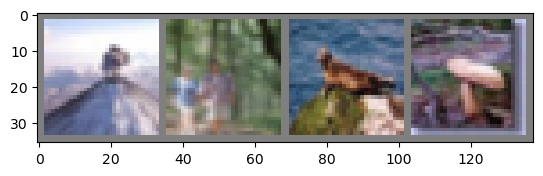

GroundTruth:  mountain forest seal  mushroom


In [ ]:
dataiter = iter(testloader) # 获取测试数据集的迭代器
images, labels = next(dataiter) # 获取测试数据集的第一个 batch

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))


第一个 batch 的预测结果


In [ ]:
outputs = net(images)
print(outputs)

_, predicted = torch.max(outputs, 1) # 获取最大值的索引

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))


tensor([[-3.7739e+00, -2.4563e+00,  1.3647e+00,  7.1117e-01, -2.0601e+00,
         -7.2641e-01, -2.3647e+00,  1.7511e+00,  3.1649e+00,  1.0584e+00,
          7.6922e-01, -2.7331e-01,  3.7020e+00, -1.4395e-01, -1.4948e+00,
         -5.9373e-01,  1.3215e+00,  3.8991e+00,  1.1474e-01, -1.7507e+00,
         -1.4059e+00, -1.2712e+00,  1.3860e-01, -6.7126e-01, -7.2942e-01,
          1.1697e-01, -5.4970e-01,  9.7760e-01, -3.2889e-01,  2.3295e+00,
          2.4520e+00, -2.7905e+00, -1.1716e+00, -1.6185e+00, -1.1074e+00,
         -1.2891e+00, -2.9564e+00,  1.4419e+00,  8.3293e-01, -1.8858e+00,
          2.4914e+00,  2.4956e+00, -8.4556e-01, -2.3965e+00, -6.9545e-01,
          8.0251e-01, -2.7073e-01, -1.4650e+00,  3.1172e+00,  4.0878e-01,
         -4.2865e-01, -2.6372e+00, -8.1289e-01, -3.5561e+00, -1.1235e+00,
          1.5137e+00,  4.5936e-01,  1.4034e+00, -9.4835e-01,  1.4994e+00,
         -2.1673e+00,  3.4152e-01, -4.1480e+00, -7.3096e-01, -9.6261e-02,
          1.3961e+00,  6.4035e-01, -8.

总准确率


In [ ]:
correct = 0
total = 0
# 因为我们不需要进行梯度计算，所以我们使用 torch.no_grad() 来减少内存开销
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1) # 取得分最高的那个类 (outputs.data 的索引号)
        total += labels.size(0) # 统计测试数据集的数量
        correct += (predicted == labels).sum().item() # 统计预测正确的数量

print(f'10000 测试集的准确率: {100 * correct // total} %')


10000 测试集的准确率: 32 %


每个类别的准确率

In [ ]:
# 统计每个类别的预测情况
# 形式为字典：{类别名称: 数量}
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
		# zip() 函数用于将可迭代的对象作为参数，将对象中对应的元素打包成一个个元组，然后返回由这些元组组成的对象
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')


Accuracy for class: apple is 39.0 %
Accuracy for class: aquarium_fish is 52.0 %
Accuracy for class: baby  is 17.0 %
Accuracy for class: bear  is 17.0 %
Accuracy for class: beaver is 9.0 %
Accuracy for class: bed   is 24.0 %
Accuracy for class: bee   is 21.0 %
Accuracy for class: beetle is 53.0 %
Accuracy for class: bicycle is 39.0 %
Accuracy for class: bottle is 47.0 %
Accuracy for class: bowl  is 10.0 %
Accuracy for class: boy   is 32.0 %
Accuracy for class: bridge is 38.0 %
Accuracy for class: bus   is 21.0 %
Accuracy for class: butterfly is 30.0 %
Accuracy for class: camel is 11.0 %
Accuracy for class: can   is 30.0 %
Accuracy for class: castle is 49.0 %
Accuracy for class: caterpillar is 13.0 %
Accuracy for class: cattle is 13.0 %
Accuracy for class: chair is 68.0 %
Accuracy for class: chimpanzee is 49.0 %
Accuracy for class: clock is 28.0 %
Accuracy for class: cloud is 49.0 %
Accuracy for class: cockroach is 54.0 %
Accuracy for class: couch is 30.0 %
Accuracy for class: cra   is 2